### Paquetes

In [1]:
import pandas as pd
from dotenv import load_dotenv
from pymongo import MongoClient
import os.path
import matplotlib.pyplot as plt
from pathlib import Path

> En este *notebook* se muestra cómo se prepararon los datos para la fase previa de la etapa de *forecasting*. Se termina obteniendo un `.csv` de datos sin huecos.

### Variables globales

In [2]:
CAMERA_NAME = "TV09-MANUEL_AZANA"
load_dotenv()
MONGO_URL = os.environ["MONGO_URL"]

### Conexión con la base de datos

Levanto la base de datos:

In [3]:
! docker start 4164842acf82

In [4]:
mongo_client = MongoClient(MONGO_URL)
db = mongo_client["traffic-analyzer"]
cam_collection = db[CAMERA_NAME]

### Carga la colección en un DataFrame

In [5]:
df = pd.DataFrame(list(cam_collection.find()))

### Preprocesa los datos en crudo

In [6]:
df

,_id,datetime,n_vehicles,n_pedestrians,bboxes
0,62a97ceb582ab9d4525c5100,2022-05-10 00:00:01.jpg,0,1,"[[0.5247328877449036, 0.5176894068717957, 0.01..."
1,62a97cec582ab9d4525c5101,2022-05-10 00:00:06.jpg,0,1,"[[0.52483731508255, 0.5176885724067688, 0.0151..."
2,62a97ced582ab9d4525c5102,2022-05-10 00:00:11.jpg,0,1,"[[0.8930602669715881, 0.5756371021270752, 0.01..."
3,62a97cee582ab9d4525c5103,2022-05-10 00:00:17.jpg,0,1,"[[0.5244811177253723, 0.5179900527000427, 0.01..."
4,62a97cef582ab9d4525c5104,2022-05-10 00:00:22.jpg,0,1,"[[0.8933563828468323, 0.5756476521492004, 0.01..."
...,...,...,...,...,...
238190,62ac7056582ab9d4525ff36e,2022-06-06 06:19:14.jpg,7,0,"[[0.6470062732696533, 0.4140307605266571, 0.09..."
238191,62ac7057582ab9d4525ff36f,2022-06-06 06:19:19.jpg,14,1,"[[0.6474121809005737, 0.41396310925483704, 0.0..."
238192,62ac7058582ab9d4525ff370,2022-06-06 06:19:24.jpg,10,0,"[[0.6226086616516113, 0.39051368832588196, 0.0..."
238193,62ac7059582ab9d4525ff371,2022-06-06 06:19:29.jpg,11,1,"[[0.5348842144012451, 0.31243568658828735, 0.0..."


In [7]:
df["datetime"] = df["datetime"].str.slice_replace(19, 23, "") # quito lo del .jpg (me equivoqué)
df["datetime"] = pd.to_datetime(df["datetime"]) # paso la fecha de string a datetime
df = df[["datetime", "n_vehicles"]] # me centro en las columnas de tiempo y número de vehículos
df = df.set_index("datetime") # hago la columna datetime el índice
df = df.sort_values(by="datetime") # ordeno por fecha

### Gráfica de los datos en crudo

Se observa la discontinuidad en los datos debido a los baneos por parte del Ayuntamiento de Málaga. EL 9 de Mayo se comenzó a hacer peticiones al portal de datos abiertos del Ayunatamiento de Málaga. El 18 de Mayo se produjo el primer baneo. El 20 de Mayo se volvió a hacer peticiones desde otra máquina, que también se baneó el 23 de Mayo. 

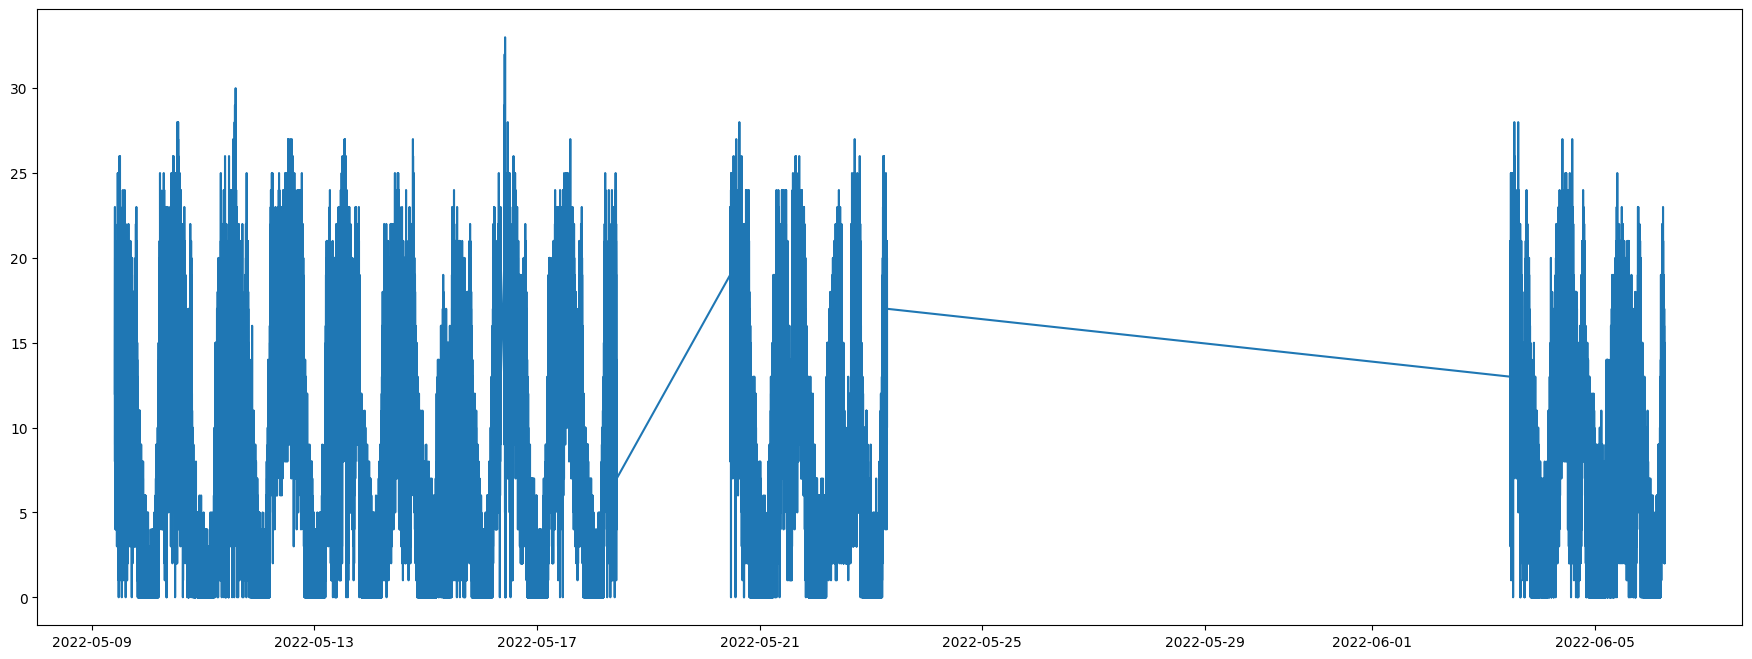

In [8]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"])

Tras observar la gráfica, se decide desechar los datos desde el 23 de Mayo (incluido) en adelante. Trabajaremos con los datos desde el **9 de Mayo** hasta el **22 de Mayo** (ambos incluidos). Eso hace un total de 2 semanas de datos.

### Gráfica en zoom de los datos en crudo

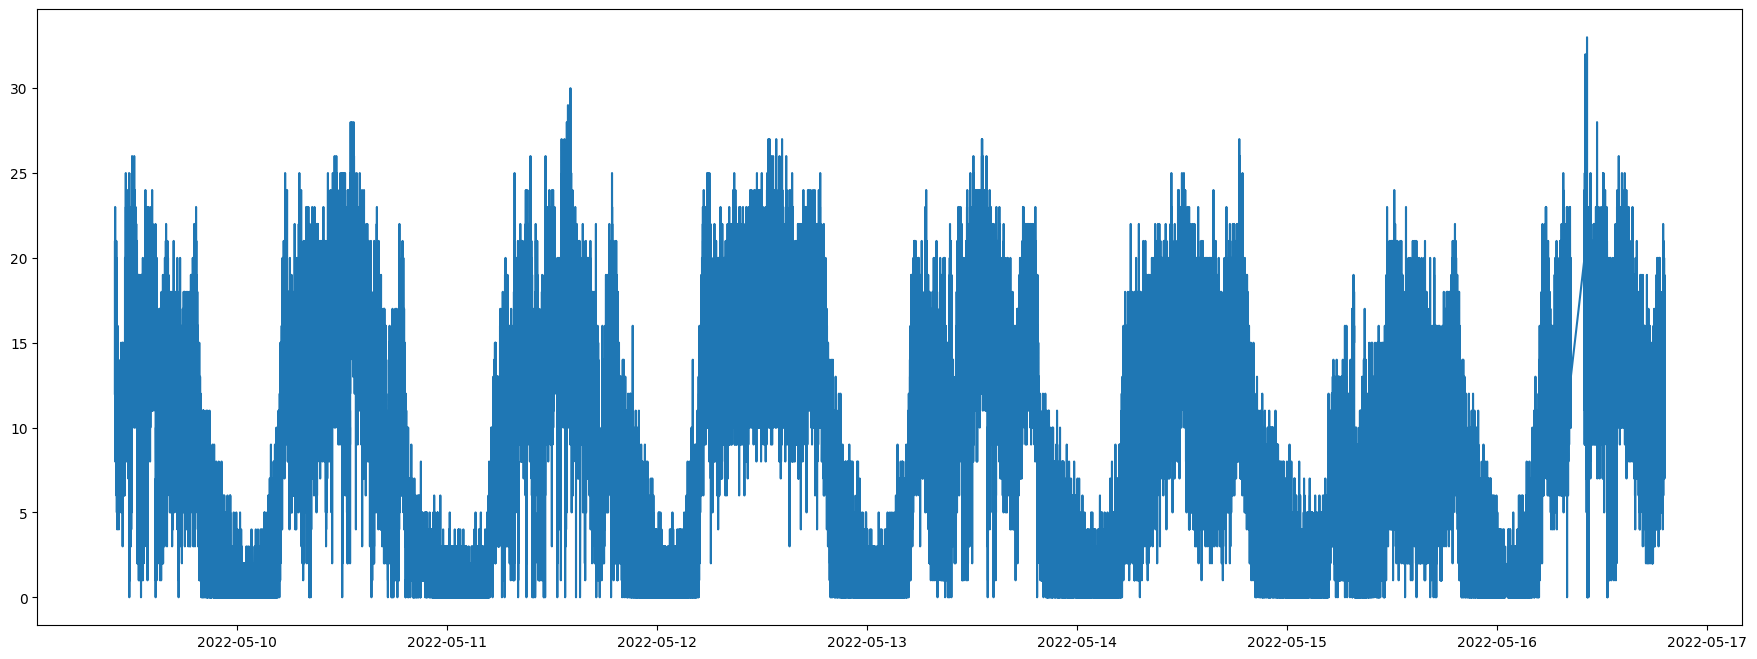

In [9]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"][:120000])

Se observa una disminución de tráfico el 15 de Mayo, algo que tiene sentido al ser un Domingo.

### Acotamos los datos entre las fechas `2022-05-09 : 2022-05-23`

In [10]:
df = df.loc['2022-05-09':'2022-05-23']

Nos quedaremos con los datos que van desde el **Lunes 9/5 (10:00) hasta Lunes 23/5 (10:00)** (dos semanas). El problema es que el **Miércoles 18/5** me cortan acceso a las 10:00. Me vuelvo a conectar el **Viernes 20/5** a las 11:00, perdiendo unas 48 horas de datos aproximadamente.

### Gráfica de las 2 semanas de datos que se usarán

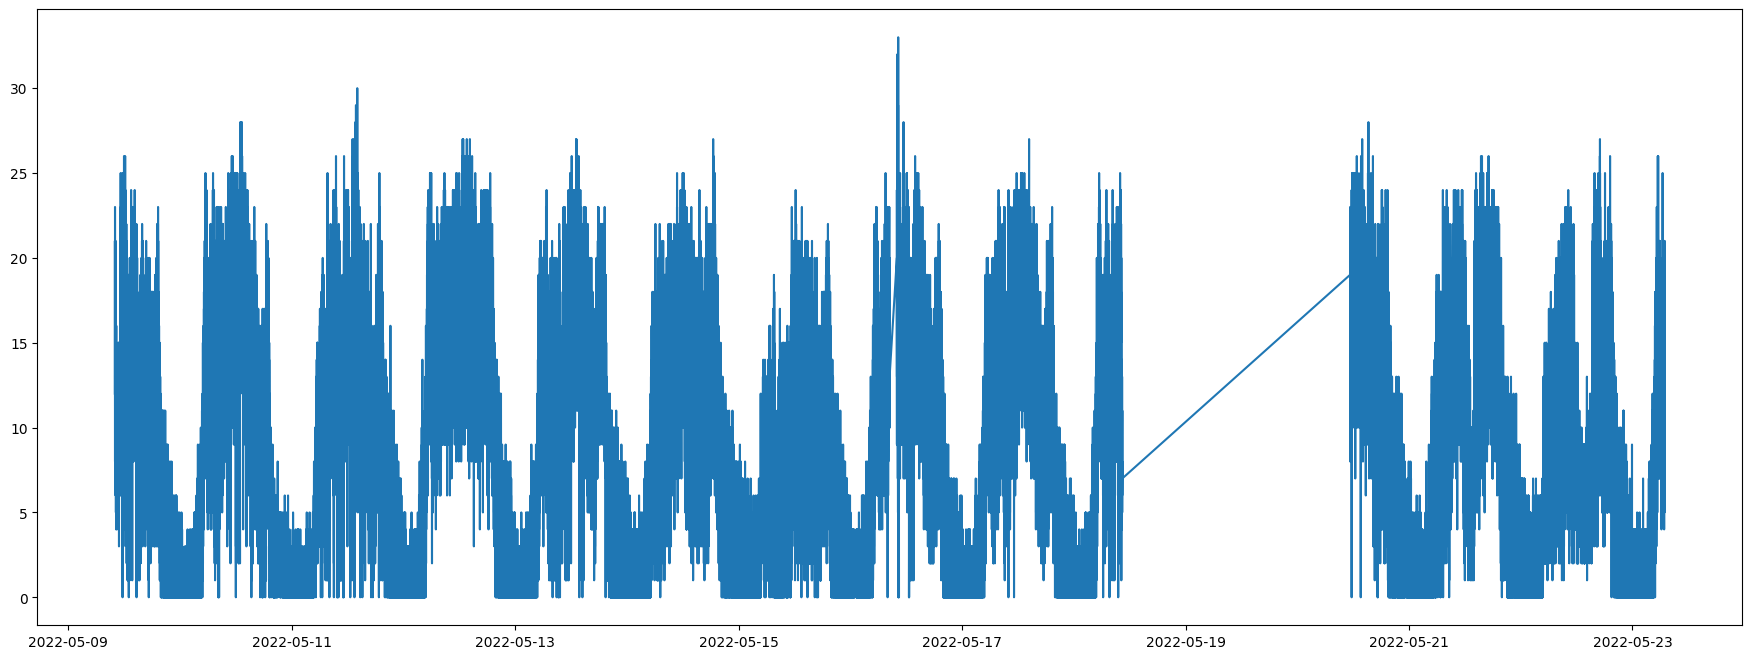

In [11]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"])

Se observa el parón de 48 horas por el baneo y un pequeño parón de 2 horas el día 16 por falta de señal.

### Gráfica en zoom del parón de 2 horas

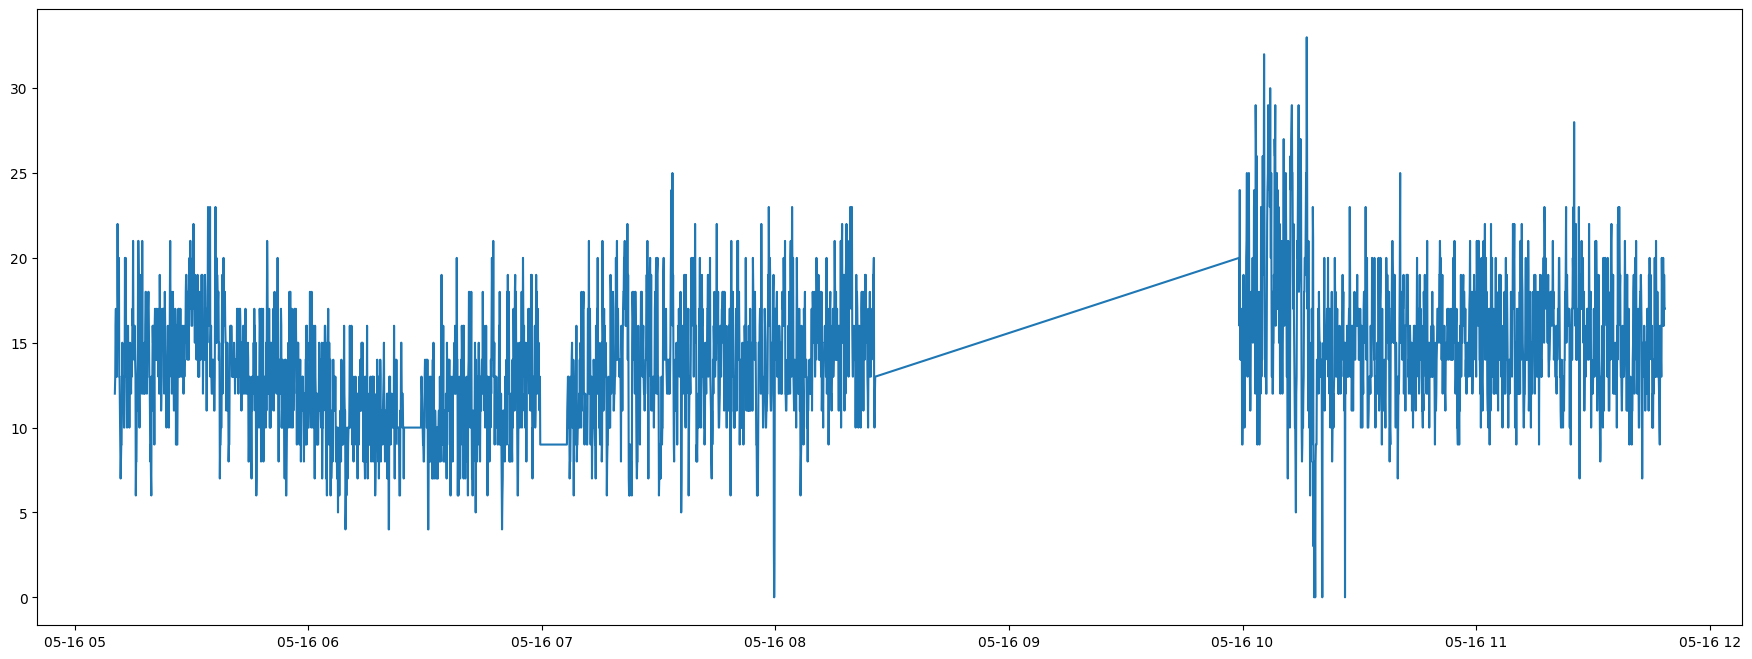

In [12]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"][111500:115000]) 

Se observa que el pequeño parón empieza el 16 de Mayo a las 8:25. Se vuelven a recibir imágenes a las 10:00.
También hay algunas anomalías a las 7:00.

### Aumento de datos para suplir el baneo de 48 horas

Se optó por hacer un aumento de datos para poder disponer de las 2 semanas al completo. Es importante disponer al menos de dos semanas, puesto que visualmente parece que la estacionalidad es 1 semana y el ciclo se repite. Para suplir los datos que faltan, cogeremos los datos correspodientes a los mismos día, pero de la semana anterior. Cambiaremos ligeramente y aleatoriamente esos datos para que no sean exactamente iguales.

> Extraemos los datos que vamos a aumentar. Las 24 horas del Miércoles 11 de Mayo se modificarán ligeramente para usarlas como las 24 horas del Miércoles 18 de Mayo (que se nos baneó a las 10:00). Las 24 horas del Jueves 12 de Mayo se modificarán ligeramente para usarlas como las 24 horas del Jueves 19 de Mayo (que no se recogió ningún dato). Las 24 horas del Viernes 13 de Mayo se modificarán ligeramente para usarlas como las 24 horas del Viernes 20 de Mayo.

In [13]:
sample = df.loc['2022-05-11':'2022-05-13']

> Aumentamos los datos usando una máximo de modificación de 3 vehículos con respecto al valor original.

In [14]:
from tsaug import Drift
augmenter = (Drift(max_drift=0.05))
aug = augmenter.augment(sample["n_vehicles"].to_numpy())

Comprobamos que los valores se parecen

In [15]:
len(aug) == len(sample)

True

In [16]:
aug[0:200]

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1,
       2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 2, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 3, 2, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 2, 1, 0, 1, 3, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 2, 1, 5,
       0, 0])

In [17]:
sample["n_vehicles"].to_numpy()[0:200] 

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1,
       2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 2, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 3, 2, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 2, 1, 0, 1, 3, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 2, 2, 2, 0, 1,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 2, 1, 5,
       0, 0])

In [18]:
aug = pd.DataFrame(aug, columns=["n_vehicles"])

aug[aug["n_vehicles"] < 0]
aug[aug["n_vehicles"] > 0]

,n_vehicles
2,1
5,1
8,1
10,1
14,1
...,...
49102,2
49103,1
49104,1
49105,4


In [19]:
sample[sample["n_vehicles"] < 0]
sample[sample["n_vehicles"] > 0]

,n_vehicles
datetime,
2022-05-11 00:00:14,1
2022-05-11 00:00:30,1
2022-05-11 00:00:45,1
2022-05-11 00:00:56,1
2022-05-11 00:01:16,1
...,...
2022-05-13 23:59:32,2
2022-05-13 23:59:37,1
2022-05-13 23:59:42,1


### Colocamos los datos aumentados en el hueco

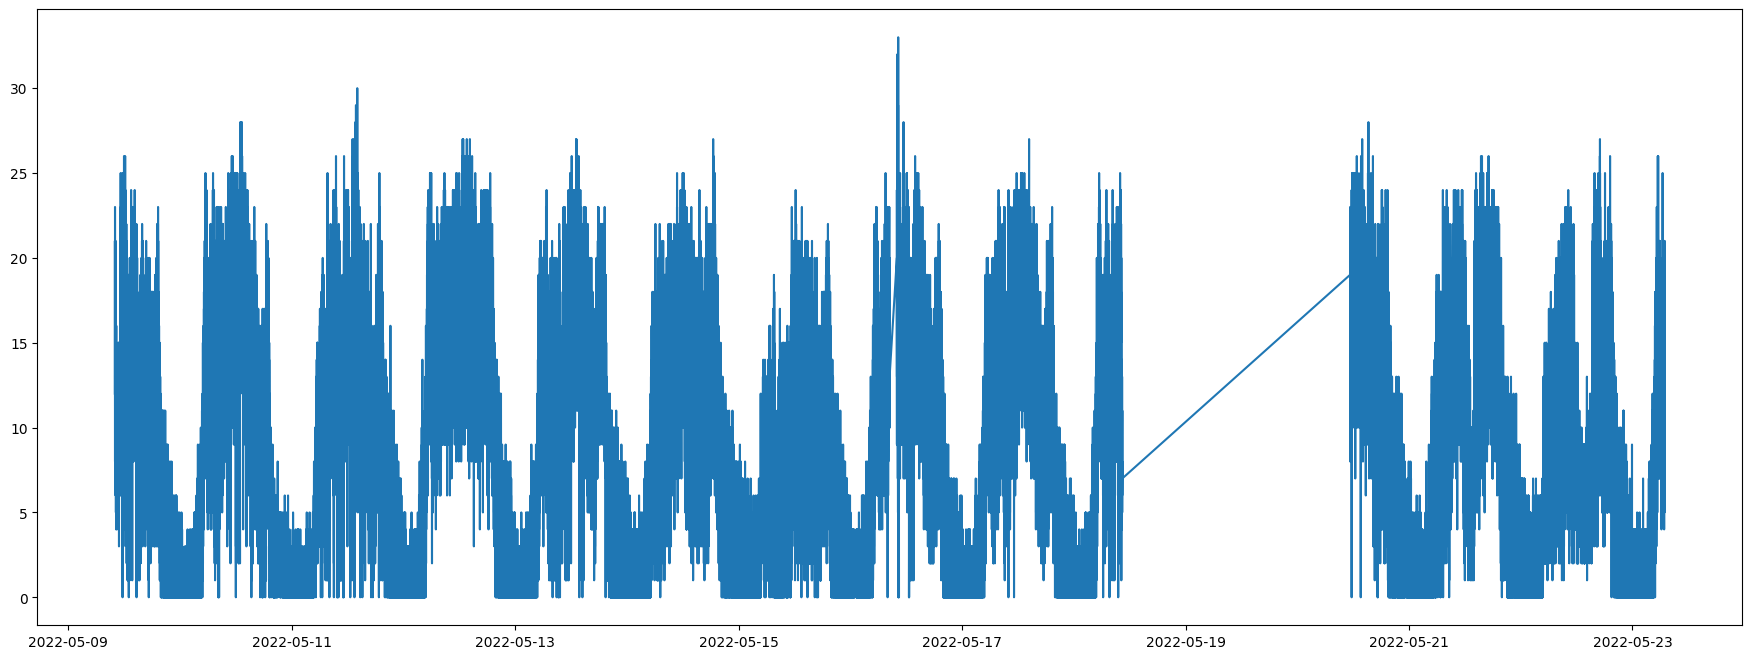

In [20]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"])

Vamos a trabajar con 3 grupos. EL primer grupo contiene los datos desde el Lunes 9/5 hasta el Martes 17/5 (incluidos). Es segundo grupo corresponde a los datos aumentados: Miércoles 18/5 al Viernes 20/5 (incluidos). El tercer grupo corresponde con los datos del Sábado 21/5 hasta el Lunes 23/5 (incluidos).

In [21]:
group_1 = df.loc['2022-05-09':'2022-05-17']
group_2 = aug
group_3 = df.loc['2022-05-21':'2022-05-23']

Ahora podemos concatenar esos tres `Dataframes`. Pero antes tenemos que añadir la columna `datetime` a los datos aumentados, pero añadiendole 7 días a cada fecha.

In [22]:
group_2.index = sample.index # le ponemos el mismo índice que los de la semana anterior
group_2.index = group_2.index + pd.DateOffset(days=7) # le sumamos 7 a las fechas de la semana anterior

> Concatenamos los 3 dataframes.

In [23]:
df = pd.concat([group_1, group_2, group_3])

In [24]:
df[df["n_vehicles"] < 0] = 0

### Datos tras rellenar el hueco con los datos aumentados

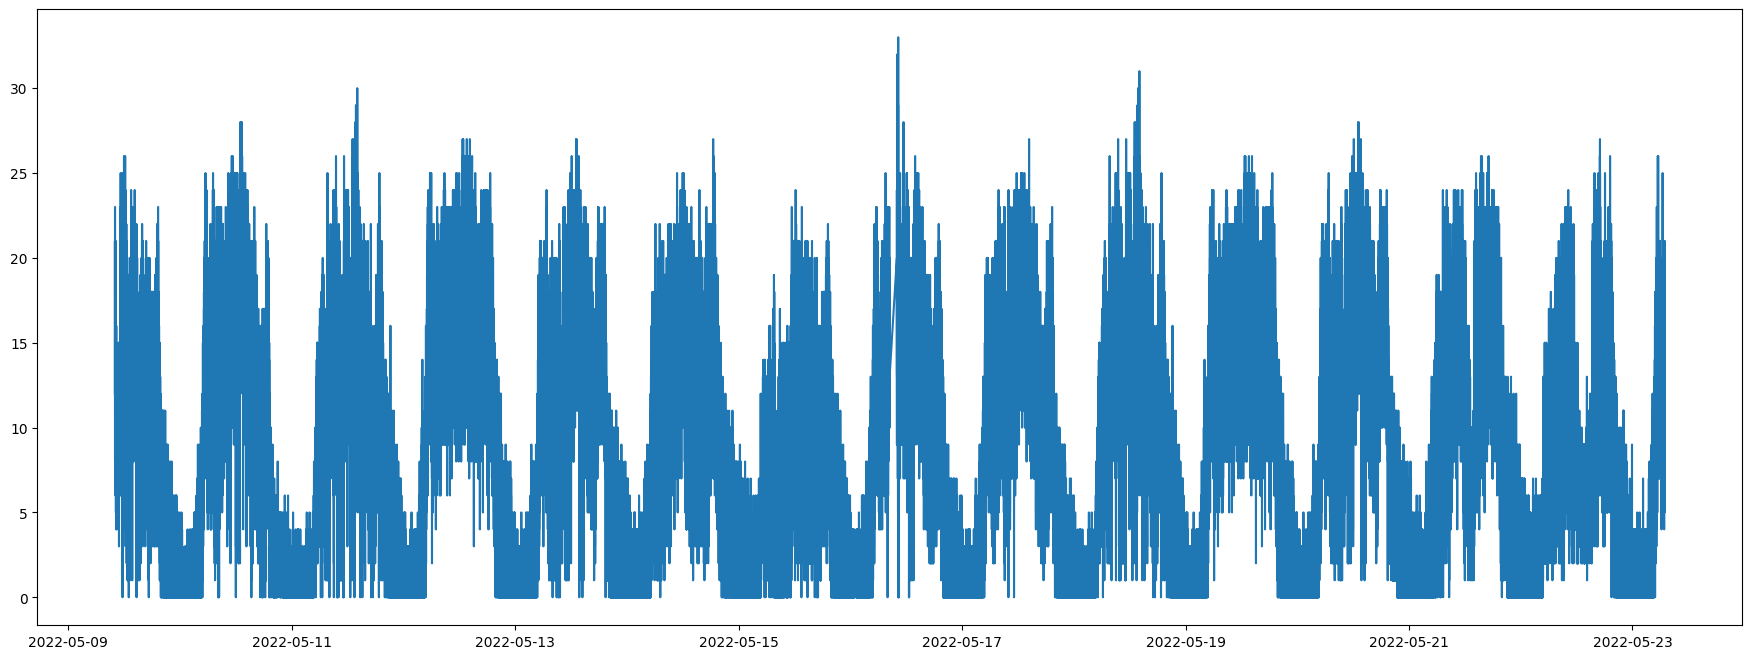

In [25]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"])

### Ahora vamos a hacer lo mismo con las 2 horas de datos corruptos

Cogemos esas mismas dos horas en la semana anterior y hacemos aumento de datos para obtener las 2 horas perdidas.
Como el mismo día de la semana anterior es lunes y no tenemos las horas que nos hacen falta, se cogerán esas horas del martes en su lugar.

> Separamos los datos en 3 grupos: antes del pequeño parón, los datos aumentados y después del parón.

In [26]:
hours = df.loc['2022-05-10 08:25:40':'2022-05-10 09:59:04']
augmenter = (Drift(max_drift=0.05))
aug = augmenter.augment(hours["n_vehicles"].to_numpy())
aug = pd.DataFrame(aug, columns=["n_vehicles"])
group_1 = df.loc['2022-05-09':'2022-05-16 08:25:39']
group_2 = hours
group_3 = df.loc['2022-05-16 09:59:05':'2022-05-23']
group_2.index = hours.index 
group_2.index = group_2.index + pd.DateOffset(days=6) # le sumamos 6 a las fechas de la semana anterior
df = pd.concat([group_1, group_2, group_3])
df.to_csv("ts_tv08.csv")

Si tras el aumento de datos obtenenmos datos negativos:

In [27]:
df[df["n_vehicles"] < 0] = 0

### Gráfica de cómo queda al final la serie temporal

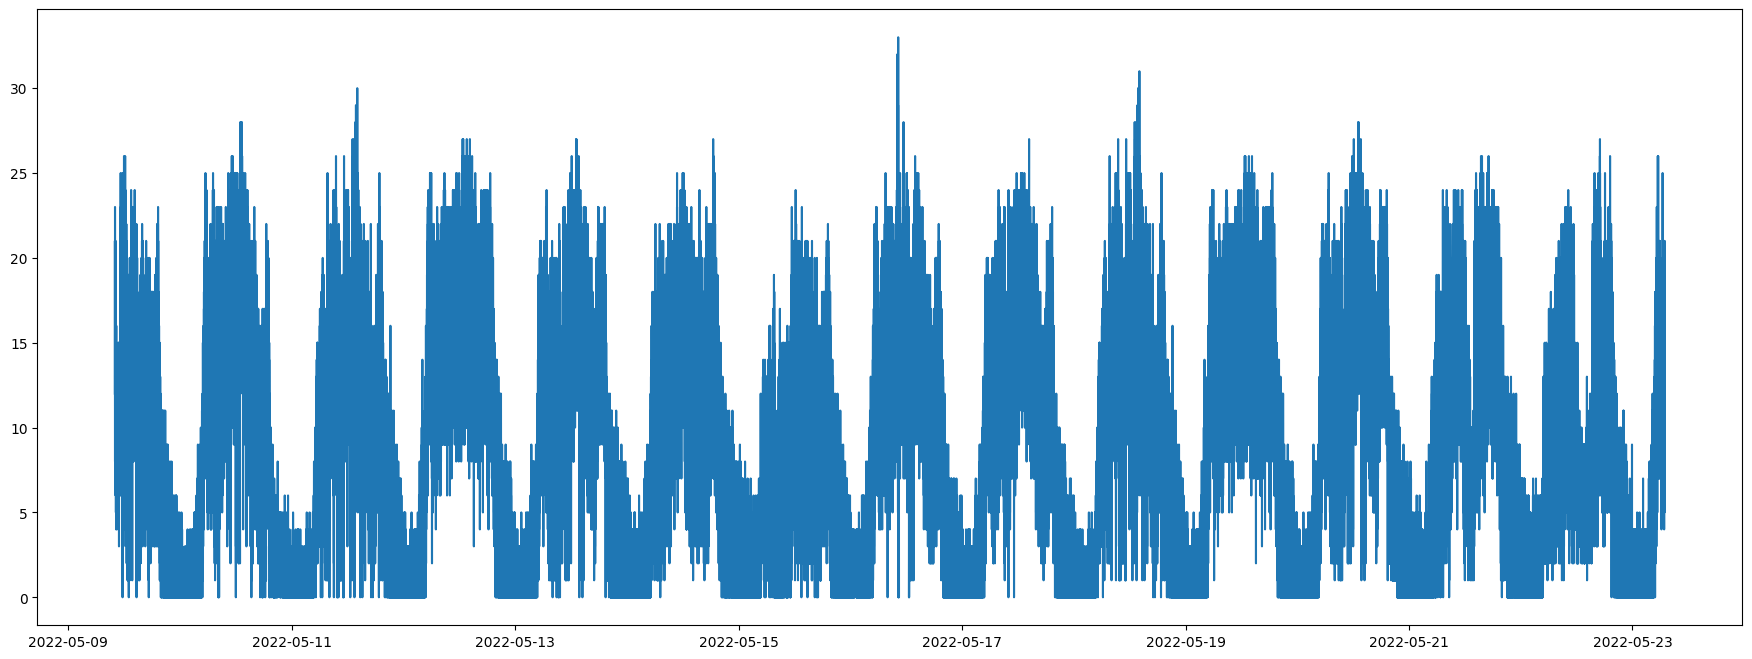

In [28]:
fig, axis = plt.subplots(facecolor="white", figsize=(22, 8))
axis.plot(df["n_vehicles"])

In [29]:
path = Path("/home/salva/PycharmProjects/traffic-analyzer-tfg/Data Forecasting") / "CSV" / str(CAMERA_NAME + ".csv")
df.to_csv(path.as_posix())